# 2022 DC service

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# load data
df = pd.read_csv("311_City_Service_Requests_in_2022.csv")
# check data
df.head()

/tmp/ipykernel_8212/2035065394.py:2: DtypeWarning: Columns (0: DETAILS) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("311_City_Service_Requests_in_2022.csv")


,X,Y,SERVICEREQUESTID,STREETADDRESS,CITY,STATE,ZIPCODE,WARD,SERVICECODE,SERVICECODEDESCRIPTION,...,XCOORD,YCOORD,LATITUDE,LONGITUDE,MARADDRESSREPOSITORYID,GLOBALID,CREATED,EDITED,OBJECTID,SE_ANNO_CAD_DATA
0,397507.44,140803.78,22-00000005,3620 11TH STREET NW,WASHINGTON,DC,20010.0,Ward 1,S0441,Trash Collection - Missed,...,397507.44,140803.78,38.935116,-77.028749,230397,{D4800EAA-488F-7440-E053-792F520AC392},NaN,NaN,10050224,NaN
1,397653.87,140003.18,22-00000006,3003 11TH STREET NW,WASHINGTON,DC,20001.0,Ward 1,S0181,Illegal Dumping,...,397653.87,140003.18,38.927904,-77.027057,231227,{D4800EAA-4890-7440-E053-792F520AC392},NaN,NaN,10050449,NaN
2,400044.36,143069.15,22-00000010,401 KENNEDY STREET NE,WASHINGTON,DC,20011.0,Ward 5,S0031,Bulk Collection,...,400044.36,143069.15,38.955526,-76.999488,28158,{D4800EAA-4891-7440-E053-792F520AC392},NaN,NaN,10050450,NaN
3,402389.29,139113.44,22-00000016,2135 QUEENS CHAPEL ROAD NE,WASHINGTON,DC,20018.0,Ward 5,S0261,Parking Enforcement,...,402389.29,139113.44,38.919888,-76.972448,286671,{D481BFEE-13F7-6BC3-E053-792F520A91CF},NaN,NaN,10050451,NaN
4,398585.56,133829.44,22-00000017,325 P STREET SW,WASHINGTON,DC,20024.0,Ward 6,S0261,Parking Enforcement,...,398585.56,133829.44,38.872290,-77.016300,276559,{D481BFEE-13F8-6BC3-E053-792F520A91CF},NaN,NaN,10050452,NaN


In [6]:
# basic exploration
print("rows, cols:", df.shape)

# column types
pd.DataFrame({"dtype": df.dtypes}).T

# missing values (top 15)
df.isna().sum().sort_values(ascending=False).head(15)

# numeric summary
num_cols = df.select_dtypes(include="number")
num_cols.describe().T

# categorical summary (top 15 by distinct count)
cat_cols = df.select_dtypes(include="object")
cat_cols.nunique().sort_values(ascending=False).head(15)

rows, cols: (386740, 34)


/tmp/ipykernel_8212/205506763.py:15: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include="object")


SERVICEREQUESTID              386740
GLOBALID                      386740
ADDDATE                       380970
SERVICEORDERDATE              380970
RESOLUTIONDATE                374665
SERVICEDUEDATE                296159
STREETADDRESS                 104172
SERVICECODEDESCRIPTION           128
SERVICECODE                      122
SERVICETYPECODEDESCRIPTION        24
ORGANIZATIONACRONYM               12
WARD                               9
SERVICEORDERSTATUS                 9
PRIORITY                           6
DETAILS                            4
dtype: int64

In [7]:
# -----------------------------
# 1) Normalize column names
# -----------------------------
df.columns = [c.strip() for c in df.columns]
colmap = {c: c.upper().replace(" ", "_") for c in df.columns}
df = df.rename(columns=colmap)

print("Example columns after normalization:")
print(df.columns[:30])

# -----------------------------
# 1.1) Helper: find a column by candidate names
# -----------------------------
def find_col(cols, candidates):
    """Return the first matching column name from a list of candidates."""
    for cand in candidates:
        if cand in cols:
            return cand
    return None

cols = set(df.columns)

created_col = find_col(cols, ["CREATED_DATE", "CREATEDDATE", "DATE_CREATED", "REQUESTED_DATE", "REQUESTEDDATE"])
closed_col  = find_col(cols, ["CLOSED_DATE", "CLOSEDDATE", "DATE_CLOSED", "RESOLVED_DATE", "RESOLVEDDATE"])
type_col    = find_col(cols, ["SERVICE_TYPE", "REQUESTTYPE", "REQUEST_TYPE", "SERVICECODEDESCRIPTION", "SERVICE_NAME"])
ward_col    = find_col(cols, ["WARD", "WARD_ID", "WARDID"])
lat_col     = find_col(cols, ["LATITUDE", "LAT"])
lon_col     = find_col(cols, ["LONGITUDE", "LON", "LONG"])

print("Detected columns:")
print(" created_col:", created_col)
print(" closed_col :", closed_col)
print(" type_col   :", type_col)
print(" ward_col   :", ward_col)
print(" lat/lon    :", lat_col, lon_col)


Example columns after normalization:
Index(['X', 'Y', 'SERVICEREQUESTID', 'STREETADDRESS', 'CITY', 'STATE',
       'ZIPCODE', 'WARD', 'SERVICECODE', 'SERVICECODEDESCRIPTION',
       'SERVICETYPECODEDESCRIPTION', 'ORGANIZATIONACRONYM', 'SERVICECALLCOUNT',
       'ADDDATE', 'RESOLUTIONDATE', 'SERVICEDUEDATE', 'SERVICEORDERDATE',
       'INSPECTIONFLAG', 'INSPECTIONDATE', 'INSPECTORNAME',
       'SERVICEORDERSTATUS', 'STATUS_CODE', 'DETAILS', 'PRIORITY', 'XCOORD',
       'YCOORD', 'LATITUDE', 'LONGITUDE', 'MARADDRESSREPOSITORYID',
       'GLOBALID'],
      dtype='str')
Detected columns:
 created_col: None
 closed_col : None
 type_col   : SERVICECODEDESCRIPTION
 ward_col   : WARD
 lat/lon    : LATITUDE LONGITUDE


Extract the mean of LATITUDE / LONGITUDE

In [4]:


# df = your 311 dataframe

# make sure coordinates are numeric
df["LATITUDE"] = pd.to_numeric(df["LATITUDE"], errors="coerce")
df["LONGITUDE"] = pd.to_numeric(df["LONGITUDE"], errors="coerce")

# (optional) standardize ward labels a bit
df["WARD"] = df["WARD"].astype(str).str.strip()

ward_centers = (
    df.dropna(subset=["WARD", "LATITUDE", "LONGITUDE"])
      .groupby("WARD", as_index=False)[["LATITUDE", "LONGITUDE"]]
      .mean()
      .rename(columns={"LATITUDE": "avg_latitude", "LONGITUDE": "avg_longitude"})
      .sort_values("WARD")
)

ward_centers

,WARD,avg_latitude,avg_longitude
0,Null,38.912701,-77.016626
1,Ward 1,38.926380,-77.030913
2,Ward 2,38.906555,-77.042828
3,Ward 3,38.939468,-77.078592
4,Ward 4,38.958344,-77.026256
5,Ward 5,38.923135,-76.992625
6,Ward 6,38.891468,-76.998251
7,Ward 7,38.887394,-76.945232
8,Ward 8,38.850980,-76.990264


# Pothole distribution

In [8]:
# ---- 1) Identify pothole rows (robust text match) ----
type_col = "SERVICECODEDESCRIPTION"
ward_col = "WARD"
lat_col, lon_col = "LATITUDE", "LONGITUDE"

# normalize
df[type_col] = df[type_col].astype(str).str.strip()
df[ward_col] = df[ward_col].astype(str).str.strip()
df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")

# pothole filter (covers variations like "Pothole", "Potholes", etc.)
pothole_mask = df[type_col].str.contains(r"\bpothole(s)?\b", case=False, na=False)
potholes = df.loc[pothole_mask].copy()

print("Total rows:", len(df))
print("Pothole rows:", len(potholes))
print("Unique wards in potholes:", potholes[ward_col].nunique())

Total rows: 386740
Pothole rows: 3484
Unique wards in potholes: 9


/tmp/ipykernel_8212/2330827191.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pothole_mask = df[type_col].str.contains(r"\bpothole(s)?\b", case=False, na=False)


In [9]:
pothole_by_ward = (
    potholes.groupby(ward_col)
            .size()
            .rename("n_potholes")
            .reset_index()
            .sort_values("n_potholes", ascending=False)
)

pothole_by_ward["share"] = pothole_by_ward["n_potholes"] / pothole_by_ward["n_potholes"].sum()
pothole_by_ward

,WARD,n_potholes,share
3,Ward 3,587,0.168485
5,Ward 5,499,0.143226
7,Ward 7,452,0.129736
4,Ward 4,418,0.119977
2,Ward 2,413,0.118542
6,Ward 6,397,0.113949
8,Ward 8,368,0.105626
1,Ward 1,290,0.083238
0,Null,60,0.017222


In [10]:
# keep only valid coords
pgeo = potholes.dropna(subset=[lat_col, lon_col]).copy()

# bin into a grid (tune decimals: 3 ~ ~110m, 4 ~ ~11m lat-wise)
grid_decimals = 3
pgeo["lat_bin"] = pgeo[lat_col].round(grid_decimals)
pgeo["lon_bin"] = pgeo[lon_col].round(grid_decimals)

hotspots = (
    pgeo.groupby(["lat_bin", "lon_bin"])
        .size()
        .rename("n")
        .reset_index()
        .sort_values("n", ascending=False)
)

hotspots.head(20)

,lat_bin,lon_bin,n
922,38.906,-76.981,21
621,38.895,-76.949,15
311,38.876,-77.018,14
1405,38.928,-77.030,13
869,38.904,-76.924,11
92,38.844,-76.994,9
974,38.908,-76.980,9
458,38.886,-76.936,9
1682,38.943,-77.081,9
891,38.905,-77.002,8


In [11]:
date_col = "ADDDATE"  # change to SERVICEORDERDATE if that better reflects "reported"
potholes[date_col] = pd.to_datetime(potholes[date_col], errors="coerce")

pt = potholes.dropna(subset=[date_col]).copy()
pt["month"] = pt[date_col].dt.to_period("M").astype(str)
pt["dow"] = pt[date_col].dt.day_name()
pt["week"] = pt[date_col].dt.to_period("W").astype(str)

monthly = pt.groupby("month").size().rename("n").reset_index()
weekly = pt.groupby("week").size().rename("n").reset_index()
dow = (pt.groupby("dow").size().rename("n").reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
).reset_index())

monthly, dow.head()

/tmp/ipykernel_8212/3007930343.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  pt["month"] = pt[date_col].dt.to_period("M").astype(str)
/tmp/ipykernel_8212/3007930343.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  pt["week"] = pt[date_col].dt.to_period("W").astype(str)


(      month    n
 0   2022-01  246
 1   2022-02  518
 2   2022-03  396
 3   2022-04  380
 4   2022-05  388
 5   2022-06  253
 6   2022-07  231
 7   2022-08  254
 8   2022-09  190
 9   2022-10  200
 10  2022-11  182
 11  2022-12  245
 12  2023-01    1,
          dow    n
 0     Monday  542
 1    Tuesday  600
 2  Wednesday  562
 3   Thursday  581
 4     Friday  525)

/tmp/ipykernel_8212/2835324888.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  potholes = df[df[type_col].str.contains(r"\bpothole(s)?\b", case=False, na=False)].copy()


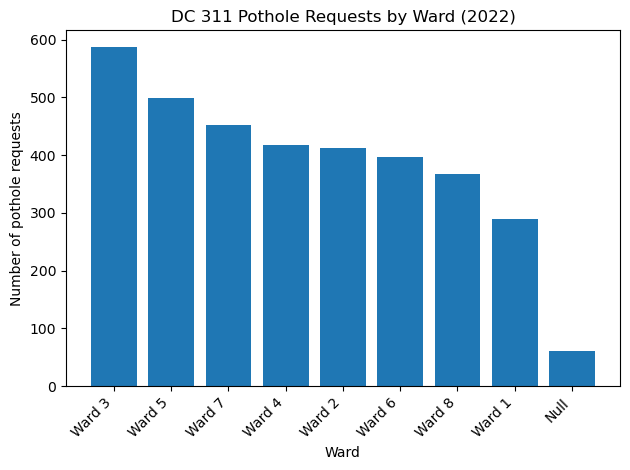

/tmp/ipykernel_8212/2835324888.py:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  pt["month"] = pt[date_col].dt.to_period("M").dt.to_timestamp()


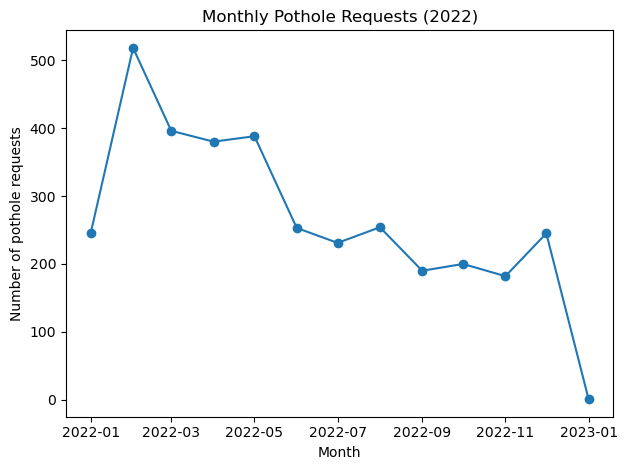

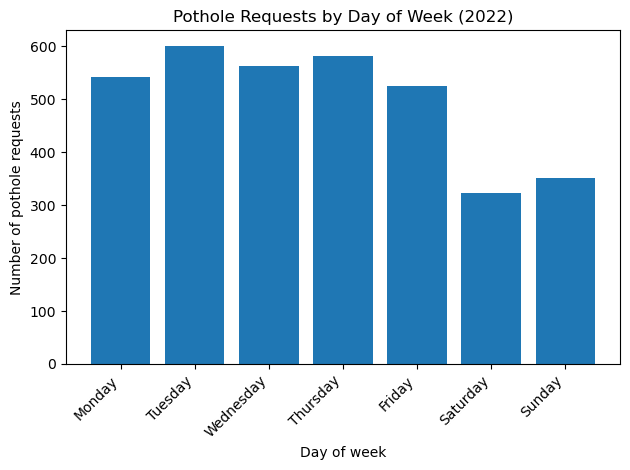

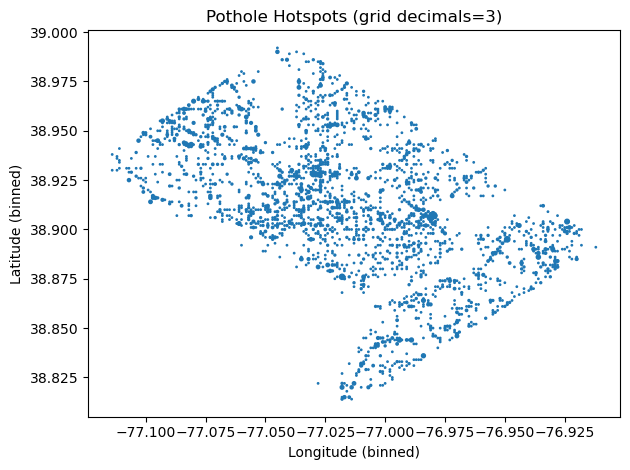

In [13]:
# df = pd.read_csv("311_City_Service_Requests_in_2022.csv")

type_col = "SERVICECODEDESCRIPTION"
ward_col = "WARD"
lat_col, lon_col = "LATITUDE", "LONGITUDE"
date_col = "ADDDATE"  # or "SERVICEORDERDATE"

# ---- prep ----
df[type_col] = df[type_col].astype(str).str.strip()
df[ward_col] = df[ward_col].astype(str).str.strip()
df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")

potholes = df[df[type_col].str.contains(r"\bpothole(s)?\b", case=False, na=False)].copy()

# ---- A) Bar chart: potholes by ward ----
pothole_by_ward = (
    potholes.groupby(ward_col).size().rename("n_potholes").reset_index()
            .sort_values("n_potholes", ascending=False)
)
plt.figure()
plt.bar(pothole_by_ward[ward_col], pothole_by_ward["n_potholes"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Ward"); plt.ylabel("Number of pothole requests")
plt.title("DC 311 Pothole Requests by Ward (2022)")
plt.tight_layout(); plt.show()

# ---- C1) Line chart: monthly seasonality ----
potholes[date_col] = pd.to_datetime(potholes[date_col], errors="coerce")
pt = potholes.dropna(subset=[date_col]).copy()
pt["month"] = pt[date_col].dt.to_period("M").dt.to_timestamp()
monthly = pt.groupby("month").size().rename("n").reset_index().sort_values("month")

plt.figure()
plt.plot(monthly["month"], monthly["n"], marker="o")
plt.xlabel("Month"); plt.ylabel("Number of pothole requests")
plt.title("Monthly Pothole Requests (2022)")
plt.tight_layout(); plt.show()

# ---- C2) Bar chart: day-of-week pattern ----
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pt["dow"] = pt[date_col].dt.day_name()
dow = pt.groupby("dow").size().rename("n").reindex(dow_order).reset_index()

plt.figure()
plt.bar(dow["dow"], dow["n"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Day of week"); plt.ylabel("Number of pothole requests")
plt.title("Pothole Requests by Day of Week (2022)")
plt.tight_layout(); plt.show()

# ---- B) Spatial hotspots: binned grid scatter (marker size = counts) ----
pgeo = potholes.dropna(subset=[lat_col, lon_col]).copy()
grid_decimals = 3  # try 3 (coarser) or 4 (finer)
pgeo["lat_bin"] = pgeo[lat_col].round(grid_decimals)
pgeo["lon_bin"] = pgeo[lon_col].round(grid_decimals)

hotspots = (
    pgeo.groupby(["lat_bin","lon_bin"]).size().rename("n").reset_index()
        .sort_values("n", ascending=False)
)

plt.figure()
plt.scatter(hotspots["lon_bin"], hotspots["lat_bin"], s=hotspots["n"])
plt.xlabel("Longitude (binned)"); plt.ylabel("Latitude (binned)")
plt.title(f"Pothole Hotspots (grid decimals={grid_decimals})")
plt.tight_layout(); plt.show()

# Load weather data

In [ ]:
def daily_to_weekly_features(w_daily):
    w = w_daily.copy()
    w["time"] = pd.to_datetime(w["time"])
    w["week"] = w["time"].dt.to_period("W").dt.start_time

    # numeric coercion (safe)
    num_cols = [
        "precip_mm", "rain_mm", "snow_cm", "tmax_c", "tmin_c", "rh_mean",
        "precipitation_hours (h)", "showers_sum (mm)",
        "relative_humidity_2m_max (%)", "relative_humidity_2m_min (%)"
    ]
    for c in num_cols:
        if c in w.columns:
            w[c] = pd.to_numeric(w[c], errors="coerce")

    # engineered daily signals
    w["t_range"] = w["tmax_c"] - w["tmin_c"]
    w["freeze_day"] = (w["tmin_c"] < 0).astype(int)
    w["freeze_thaw_day"] = ((w["tmin_c"] < 0) & (w["tmax_c"] > 0)).astype(int)
    w["heavy_rain_day"] = (w["rain_mm"] >= 10).astype(int)  # threshold can tune

    weekly = (w.groupby(["WARD", "week"], as_index=False)
                .agg(
                    precip_mm_sum=("precip_mm", "sum"),
                    rain_mm_sum=("rain_mm", "sum"),
                    showers_mm_sum=("showers_sum (mm)", "sum"),
                    precip_hours_sum=("precipitation_hours (h)", "sum"),
                    snow_cm_sum=("snow_cm", "sum"),

                    tmax_c_mean=("tmax_c", "mean"),
                    tmin_c_mean=("tmin_c", "mean"),
                    t_range_mean=("t_range", "mean"),

                    rh_mean=("rh_mean", "mean"),
                    rh_max_mean=("relative_humidity_2m_max (%)", "mean"),
                    rh_min_mean=("relative_humidity_2m_min (%)", "mean"),

                    freeze_days=("freeze_day", "sum"),
                    freeze_thaw_days=("freeze_thaw_day", "sum"),
                    heavy_rain_days=("heavy_rain_day", "sum"),
                ))
    return weekly

# ---- Ward 1 example ----
w1_daily = load_open_meteo_daily("weather/ward1-open-meteo-38.92N77.02W60m.csv", "Ward 1")
w1_weekly = daily_to_weekly_features(w1_daily)
w1_weekly.head()


,WARD,week,precip_mm_sum,rain_mm_sum,showers_mm_sum,precip_hours_sum,snow_cm_sum,tmax_c_mean,tmin_c_mean,t_range_mean,rh_mean,rh_max_mean,rh_min_mean,freeze_days,freeze_thaw_days,heavy_rain_days
0,Ward 1,2021-12-27,4.4,4.4,0.0,7.0,0.00,16.400000,9.600000,6.800000,90.500000,98.500000,77.000000,0,0,0
1,Ward 1,2022-01-03,31.1,13.5,0.0,24.0,12.32,3.385714,-4.371429,7.757143,71.285714,89.285714,56.571429,6,6,0
2,Ward 1,2022-01-10,19.0,15.5,0.0,9.0,2.45,4.128571,-4.942857,9.071429,55.571429,74.428571,43.285714,6,4,1
3,Ward 1,2022-01-17,7.2,7.2,0.0,7.0,0.00,4.128571,-4.857143,8.985714,58.285714,77.142857,40.428571,6,4,0
4,Ward 1,2022-01-24,2.8,1.2,0.0,7.0,1.12,2.242857,-4.957143,7.200000,59.285714,78.285714,43.714286,7,5,0


In [18]:
# Ward 1–8 daily -> weekly
w1_daily = load_open_meteo_daily("weather/ward1-open-meteo-38.92N77.02W60m.csv", "Ward 1")
w1_weekly = daily_to_weekly_features(w1_daily)

w2_daily = load_open_meteo_daily("weather/ward2-open-meteo-38.90N77.06W26m.csv", "Ward 2")
w2_weekly = daily_to_weekly_features(w2_daily)

w3_daily = load_open_meteo_daily("weather/ward3-open-meteo-38.93N77.09W110m.csv", "Ward 3")
w3_weekly = daily_to_weekly_features(w3_daily)

w4_daily = load_open_meteo_daily("weather/ward4-open-meteo-38.95N77.05W87m.csv", "Ward 4")
w4_weekly = daily_to_weekly_features(w4_daily)

# NOTE: ward5 file name is different (no "open-")
w5_daily = load_open_meteo_daily("weather/ward5-meteo-38.91N76.99W39m.csv", "Ward 5")
w5_weekly = daily_to_weekly_features(w5_daily)

w6_daily = load_open_meteo_daily("weather/ward6-open-meteo-38.88N76.99W30m.csv", "Ward 6")
w6_weekly = daily_to_weekly_features(w6_daily)

w7_daily = load_open_meteo_daily("weather/ward7-open-meteo-38.88N76.96W37m.csv", "Ward 7")
w7_weekly = daily_to_weekly_features(w7_daily)

w8_daily = load_open_meteo_daily("weather/ward8-open-meteo-38.86N77.00W54m.csv", "Ward 8")
w8_weekly = daily_to_weekly_features(w8_daily)

# quick check
[w.shape for w in [w1_weekly,w2_weekly,w3_weekly,w4_weekly,w5_weekly,w6_weekly,w7_weekly,w8_weekly]]

[(53, 16),
 (53, 16),
 (53, 16),
 (53, 16),
 (53, 16),
 (53, 16),
 (53, 16),
 (53, 16)]

In [27]:
weather_weekly_all = pd.concat(
    [w1_weekly,w2_weekly,w3_weekly,w4_weekly,w5_weekly,w6_weekly,w7_weekly,w8_weekly],
    ignore_index=True
)
weather_weekly_all.head()

,WARD,week,precip_mm_sum,rain_mm_sum,showers_mm_sum,precip_hours_sum,snow_cm_sum,tmax_c_mean,tmin_c_mean,t_range_mean,rh_mean,rh_max_mean,rh_min_mean,freeze_days,freeze_thaw_days,heavy_rain_days
0,Ward 1,2021-12-27,4.4,4.4,0.0,7.0,0.00,16.400000,9.600000,6.800000,90.500000,98.500000,77.000000,0,0,0
1,Ward 1,2022-01-03,31.1,13.5,0.0,24.0,12.32,3.385714,-4.371429,7.757143,71.285714,89.285714,56.571429,6,6,0
2,Ward 1,2022-01-10,19.0,15.5,0.0,9.0,2.45,4.128571,-4.942857,9.071429,55.571429,74.428571,43.285714,6,4,1
3,Ward 1,2022-01-17,7.2,7.2,0.0,7.0,0.00,4.128571,-4.857143,8.985714,58.285714,77.142857,40.428571,6,4,0
4,Ward 1,2022-01-24,2.8,1.2,0.0,7.0,1.12,2.242857,-4.957143,7.200000,59.285714,78.285714,43.714286,7,5,0


Build weekly pothole counts per ward (target)

In [29]:
df[type_col] = df[type_col].astype(str).str.strip()
df[ward_col] = df[ward_col].astype(str).str.strip()
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

potholes = df[df[type_col].str.contains(r"\bpothole(s)?\b", case=False, na=False)].dropna(subset=[date_col]).copy()
potholes["week"] = potholes[date_col].dt.to_period("W").dt.start_time
y = potholes.groupby([ward_col, "week"]).size().rename("y").reset_index()
# complete grid so zeros exist explicitly
all_wards = sorted(df[ward_col].dropna().unique())
all_weeks = pd.date_range(y["week"].min(), y["week"].max(), freq="W-MON")
grid = pd.MultiIndex.from_product([all_wards, all_weeks], names=[ward_col, "week"]).to_frame(index=False)

panel = grid.merge(y, on=[ward_col, "week"], how="left").fillna({"y": 0}).sort_values([ward_col, "week"])

panel["WARD"] = panel["WARD"].astype(str).str.strip()
panel = panel[~panel["WARD"].isin(["Null", "nan", "None", "NaN", ""])]

/tmp/ipykernel_8212/2647667580.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  potholes = df[df[type_col].str.contains(r"\bpothole(s)?\b", case=False, na=False)].dropna(subset=[date_col]).copy()
/tmp/ipykernel_8212/2647667580.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  potholes["week"] = potholes[date_col].dt.to_period("W").dt.start_time


In [30]:
cols_x = [c for c in panel_w.columns if c.endswith("_x")]
panel_w = panel_w.drop(columns=cols_x)
panel_w.columns = [c[:-2] if c.endswith("_y") else c for c in panel_w.columns]

## Merge to pothole

In [31]:
# Unify week 
panel["week"] = pd.to_datetime(panel["week"])
weather_weekly_all["week"] = pd.to_datetime(weather_weekly_all["week"])

# Unify ward 
weather_weekly_all["WARD"] = weather_weekly_all["WARD"].astype(str).str.strip()

panel_w = panel.merge(weather_weekly_all, on=["WARD","week"], how="left")

# safety: align types
panel["WARD"] = panel["WARD"].astype(str).str.strip()
weather_weekly_all["WARD"] = weather_weekly_all["WARD"].astype(str).str.strip()

panel["week"] = pd.to_datetime(panel["week"])
weather_weekly_all["week"] = pd.to_datetime(weather_weekly_all["week"])

# merge weather features onto pothole panel
panel_w = panel.merge(weather_weekly_all, on=["WARD", "week"], how="left")

# fill missing weather (ward-wise median; then global median)
weather_cols = [c for c in weather_weekly_all.columns if c not in ["WARD", "week"]]

panel_w[weather_cols] = panel_w.groupby("WARD")[weather_cols].transform(
    lambda s: s.fillna(s.median())
)
panel_w[weather_cols] = panel_w[weather_cols].fillna(panel_w[weather_cols].median())

panel_w.head()

,WARD,week,y,precip_mm_sum,rain_mm_sum,showers_mm_sum,precip_hours_sum,snow_cm_sum,tmax_c_mean,tmin_c_mean,t_range_mean,rh_mean,rh_max_mean,rh_min_mean,freeze_days,freeze_thaw_days,heavy_rain_days
0,Ward 1,2021-12-27,0.0,4.4,4.4,0.0,7.0,0.00,16.400000,9.600000,6.800000,90.500000,98.500000,77.000000,0,0,0
1,Ward 1,2022-01-03,2.0,31.1,13.5,0.0,24.0,12.32,3.385714,-4.371429,7.757143,71.285714,89.285714,56.571429,6,6,0
2,Ward 1,2022-01-10,7.0,19.0,15.5,0.0,9.0,2.45,4.128571,-4.942857,9.071429,55.571429,74.428571,43.285714,6,4,1
3,Ward 1,2022-01-17,12.0,7.2,7.2,0.0,7.0,0.00,4.128571,-4.857143,8.985714,58.285714,77.142857,40.428571,6,4,0
4,Ward 1,2022-01-24,10.0,2.8,1.2,0.0,7.0,1.12,2.242857,-4.957143,7.200000,59.285714,78.285714,43.714286,7,5,0


# predict

## order

In [32]:
# panel_w: columns include ["WARD","week","y", weather features...]
panel_w = panel_w.copy()
panel_w["WARD"] = panel_w["WARD"].astype(str).str.strip()
panel_w["week"] = pd.to_datetime(panel_w["week"])
panel_w["y"] = pd.to_numeric(panel_w["y"], errors="coerce").fillna(0)

# Keep only Ward 1-8 (optional but recommended)
panel_w = panel_w[panel_w["WARD"].str.contains(r"^Ward\s+[1-8]$", regex=True, na=False)]

# Sort for time-series feature engineering
panel_w = panel_w.sort_values(["WARD", "week"]).reset_index(drop=True)

## Feature engineering（lags + rolling + seasonality）

In [33]:
# Identify weather columns automatically (everything except keys/target)
key_cols = ["WARD", "week", "y"]
weather_cols = [c for c in panel_w.columns if c not in key_cols]

# --- Target lags (these are usually the most predictive) ---
for k in [1, 2, 4, 8]:
    panel_w[f"y_lag{k}"] = panel_w.groupby("WARD")["y"].shift(k)

# Rolling means (use shift(1) to avoid leaking current week)
panel_w["y_roll4"] = (panel_w.groupby("WARD")["y"]
                      .shift(1).rolling(4).mean()
                      .reset_index(level=0, drop=True))
panel_w["y_roll8"] = (panel_w.groupby("WARD")["y"]
                      .shift(1).rolling(8).mean()
                      .reset_index(level=0, drop=True))

# --- Weather lags (often helps: last week weather drives next week potholes) ---
for c in weather_cols:
    panel_w[f"{c}_lag1"] = panel_w.groupby("WARD")[c].shift(1)

# --- Seasonality features ---
panel_w["weekofyear"] = panel_w["week"].dt.isocalendar().week.astype(int)
panel_w["month"] = panel_w["week"].dt.month
panel_w["sin_woy"] = np.sin(2*np.pi*panel_w["weekofyear"]/52.0)
panel_w["cos_woy"] = np.cos(2*np.pi*panel_w["weekofyear"]/52.0)

# Drop rows that don't have enough history for lags/rolling
model_df = panel_w.dropna().reset_index(drop=True)

## Time-based split

In [34]:
# Define split points by date (edit to match your full range 2022-2025)
# Example: last 26 weeks as test, previous 13 weeks as validation
max_week = model_df["week"].max()
test_start = max_week - pd.Timedelta(weeks=26)
valid_start = max_week - pd.Timedelta(weeks=39)

train_df = model_df[model_df["week"] < valid_start].copy()
valid_df = model_df[(model_df["week"] >= valid_start) & (model_df["week"] < test_start)].copy()
test_df  = model_df[model_df["week"] >= test_start].copy()

print("Train weeks:", train_df["week"].min(), "->", train_df["week"].max(), "rows:", len(train_df))
print("Valid weeks:", valid_df["week"].min(), "->", valid_df["week"].max(), "rows:", len(valid_df))
print("Test  weeks:", test_df["week"].min(),  "->", test_df["week"].max(),  "rows:", len(test_df))

Train weeks: 2022-02-21 00:00:00 -> 2022-03-21 00:00:00 rows: 40
Valid weeks: 2022-03-28 00:00:00 -> 2022-06-20 00:00:00 rows: 104
Test  weeks: 2022-06-27 00:00:00 -> 2022-12-26 00:00:00 rows: 216


## Build X / y matrices（one-hot ward）

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

target = "y"

# Feature list: everything except keys + target
feature_cols = [c for c in model_df.columns if c not in ["week", "y"]]

# One-hot encode WARD so the model can learn ward-specific baselines
X_train = pd.get_dummies(train_df[feature_cols], columns=["WARD"], drop_first=False)
X_valid = pd.get_dummies(valid_df[feature_cols], columns=["WARD"], drop_first=False)
X_test  = pd.get_dummies(test_df[feature_cols],  columns=["WARD"], drop_first=False)

# Align columns across splits
X_train, X_valid = X_train.align(X_valid, join="left", axis=1, fill_value=0)
X_train, X_test  = X_train.align(X_test,  join="left", axis=1, fill_value=0)

y_train = train_df[target].values
y_valid = valid_df[target].values
y_test  = test_df[target].values

def eval_preds(name, y_true, y_pred):
    """
    Evaluate count predictions with MAE and RMSE.
    Compatible with older scikit-learn versions (no squared= argument needed).
    """
    y_pred = np.clip(np.asarray(y_pred), 0, None)  # counts must be non-negative
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)       # returns MSE
    rmse = float(np.sqrt(mse))                     # RMSE = sqrt(MSE)
    print(f"{name:24s} MAE={mae:.3f}  RMSE={rmse:.3f}")
    return mae, rmse

## Model A: Negative Binomial GLM

Normalization before predict

In [50]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def eval_preds_safe(y_true, y_pred):
    """
    Safe evaluation for count predictions.
    - Clips negatives to 0
    - Replaces inf with a robust finite cap (99.5 percentile of finite preds)
    - Computes MAE and RMSE (RMSE = sqrt(MSE), compatible with older sklearn)
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    finite = np.isfinite(y_pred)
    if finite.any():
        cap = np.nanpercentile(y_pred[finite], 99.5)
    else:
        cap = float(np.nanmax(y_true)) if np.isfinite(y_true).any() else 0.0

    y_pred = np.where(np.isfinite(y_pred), y_pred, cap)
    y_pred = np.clip(y_pred, 0, None)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    return mae, rmse

In [51]:
from sklearn.preprocessing import StandardScaler

# Identify one-hot ward columns (they start with "WARD_")
ward_oh_cols = [c for c in X_train.columns if c.startswith("WARD_")]
cont_cols = [c for c in X_train.columns if c not in ward_oh_cols]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_valid_scaled[cont_cols] = scaler.transform(X_valid[cont_cols])
X_test_scaled[cont_cols]  = scaler.transform(X_test[cont_cols])

# Now feed scaled matrices into statsmodels (as float numpy)
Xtr = to_float_matrix(X_train_scaled)
Xva = to_float_matrix(X_valid_scaled)
Xte = to_float_matrix(X_test_scaled)

import statsmodels.api as sm
Xtr_sm = sm.add_constant(Xtr, has_constant="add")
Xva_sm = sm.add_constant(Xva, has_constant="add")
Xte_sm = sm.add_constant(Xte, has_constant="add")

nb_model = sm.GLM(ytr, Xtr_sm, family=sm.families.NegativeBinomial())
nb_res = nb_model.fit(maxiter=200)

pred_valid_nb = nb_res.predict(Xva_sm)
pred_test_nb  = nb_res.predict(Xte_sm)

# evaluate (should be finite now)
nb_valid_mae, nb_valid_rmse = eval_preds_safe(yva, pred_valid_nb)
nb_test_mae,  nb_test_rmse  = eval_preds_safe(yte, pred_test_nb)

print(f"NegBin GLM (scaled) valid MAE={nb_valid_mae:.3f} RMSE={nb_valid_rmse:.3f}")
print(f"NegBin GLM (scaled) test  MAE={nb_test_mae:.3f} RMSE={nb_test_rmse:.3f}")

NegBin GLM (scaled) valid MAE=961475205413130178771300063092316908247332150246911630525978929739444317730299321732539858551626477060550705130611532627968.000 RMSE=993864762490419863070495405835588706314417585034050337061126167380219280868619209502532535459052051078802281978582311895040.000
NegBin GLM (scaled) test  MAE=19.935 RMSE=20.269


/data/rpan/miniconda3/envs/dsproj/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/data/rpan/miniconda3/envs/dsproj/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)


In [39]:
import numpy as np
import statsmodels.api as sm

def to_float_matrix(X: pd.DataFrame) -> np.ndarray:
    X = X.copy()
    # convert bool -> int
    for c in X.columns:
        if X[c].dtype == bool:
            X[c] = X[c].astype(int)
    # replace inf and fill NaN
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    # ensure float64
    return X.to_numpy(dtype=np.float64)

Xtr = to_float_matrix(X_train)
Xva = to_float_matrix(X_valid)
Xte = to_float_matrix(X_test)

Xtr_sm = sm.add_constant(Xtr, has_constant="add")
Xva_sm = sm.add_constant(Xva, has_constant="add")
Xte_sm = sm.add_constant(Xte, has_constant="add")

ytr = np.asarray(y_train, dtype=np.float64)
yva = np.asarray(y_valid, dtype=np.float64)
yte = np.asarray(y_test,  dtype=np.float64)

nb_model = sm.GLM(ytr, Xtr_sm, family=sm.families.NegativeBinomial())
nb_res = nb_model.fit(maxiter=200)

pred_valid_nb = nb_res.predict(Xva_sm)
pred_test_nb  = nb_res.predict(Xte_sm)

/data/rpan/miniconda3/envs/dsproj/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/data/rpan/miniconda3/envs/dsproj/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)


In [40]:
print("Any NaN in X_train:", np.isnan(Xtr).any())
print("Any inf in X_train:", np.isinf(Xtr).any())
print("Any NaN in y_train:", np.isnan(ytr).any())
print("Any inf in y_train:", np.isinf(ytr).any())

Any NaN in X_train: False
Any inf in X_train: False
Any NaN in y_train: False
Any inf in y_train: False


## XGBoost Poisson

In [45]:
try:
    from xgboost import XGBRegressor

    xgb = XGBRegressor(
        objective="count:poisson",
        n_estimators=2000,
        learning_rate=0.03,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
    )

    xgb.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    pred_valid_xgb = xgb.predict(X_valid)
    pred_test_xgb  = xgb.predict(X_test)

    eval_preds("XGBoost Poisson (valid)", y_valid, pred_valid_xgb)
    eval_preds("XGBoost Poisson (test)",  y_test,  pred_test_xgb)

except Exception as e:
    print("XGBoost not available or failed to run:", e)
    print("If needed: conda install -c conda-forge xgboost")

XGBoost Poisson (valid)  MAE=3.954  RMSE=4.881
XGBoost Poisson (test)   MAE=4.706  RMSE=5.490


## Comparison

In [48]:
print("valid pred finite:", np.isfinite(pred_valid_nb).mean(), "  n_inf:", np.isinf(pred_valid_nb).sum())
print("test  pred finite:", np.isfinite(pred_test_nb).mean(),  "  n_inf:", np.isinf(pred_test_nb).sum())

# show the largest predictions (helps confirm explosion)
print("Top-10 valid preds:", np.sort(pred_valid_nb)[-10:])

valid pred finite: 0.07692307692307693   n_inf: 96
test  pred finite: 0.0   n_inf: 216
Top-10 valid preds: [inf inf inf inf inf inf inf inf inf inf]


In [ ]:
def eval_preds(y_true, y_pred):
    """Return MAE and RMSE for count predictions (RMSE computed without sklearn 'squared' arg)."""
    y_pred = np.clip(np.asarray(y_pred), 0, None)  # counts must be non-negative
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    return mae, rmse

# --- Evaluate NB-GLM ---
nb_valid_mae, nb_valid_rmse = eval_preds(yva, pred_valid_nb)
nb_test_mae,  nb_test_rmse  = eval_preds(yte, pred_test_nb)

print(f"NegBin GLM (valid)  MAE={nb_valid_mae:.3f}  RMSE={nb_valid_rmse:.3f}")
print(f"NegBin GLM (test)   MAE={nb_test_mae:.3f}  RMSE={nb_test_rmse:.3f}")

# --- Put everything into a comparison table ---
# Fill in the XGBoost numbers you already have (or compute if you still have preds)
xgb_valid_mae, xgb_valid_rmse = 3.954, 4.881
xgb_test_mae,  xgb_test_rmse  = 4.706, 5.490

results = pd.DataFrame({
    "model": ["NegBin GLM", "XGBoost Poisson"],
    "valid_MAE": [nb_valid_mae, xgb_valid_mae],
    "valid_RMSE": [nb_valid_rmse, xgb_valid_rmse],
    "test_MAE":  [nb_test_mae,  xgb_test_mae],
    "test_RMSE": [nb_test_rmse, xgb_test_rmse],
})

results.sort_values("test_MAE")